# Maximum Likelihood

Really great resource / text in this notebook from Adrian Price-Whelan: https://adrian.pw/blog/fitting-a-line/

Also code snippets taken from there (don't re-invent the wheel!)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['figure.dpi']=150

### First start with an ordinary least squares fit

In [2]:
# generate some random, linear data with random error
n = 25
x = np.random.uniform(size=n)

# evaluate the true model at the given x values
y = 1.17*x + 0.1

y_err = np.random.uniform(0.05, 0.1, size=n) # randomly generate uncertainty for each data point
y = np.random.normal(y, y_err) # re-sample y data with noise

In [3]:
# get the best fit from polyfit!
alpha_fit, beta_fit = np.polyfit(x,y,1)

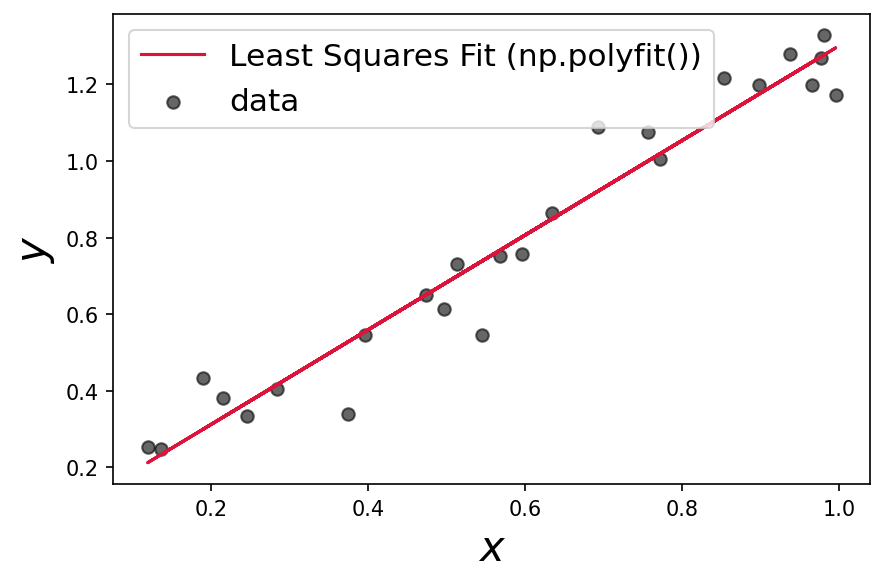

In [4]:
# plot it!
plt.figure()
plt.scatter(x, y, c='k',marker='o', label='data',alpha=0.6)
plt.plot(x, alpha_fit*x + beta_fit, c='crimson', label='Least Squares Fit (np.polyfit())')
plt.legend(fontsize=15)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$y$',fontsize=20)
plt.tight_layout()

Now we implement a negative log likelihood function, assuming our data have Gaussian, uncorrelated noise:

$$
\ln \mathcal{L}=-\frac{N}{2} \ln (2 \pi)-\frac{1}{2} \sum_{n}^{N}\left[\frac{\left(y_{n}-\left(a x_{n}+b\right)\right)^{2}}{\sigma_{n}^{2}}+\ln \sigma_{n}^{2}\right]
$$

In [5]:
# maximize the likelihood = minimize the negative log likelihood
# scipy has a built in way to 
def negative_ln_likelihood(params):
    '''
    Inputs:
    Guesses for alpha, beta in the equation y = alpha * x + beta + error
    
    Outputs:
    Negative Gausssian log-likelihood
    '''
    # get guess parameters
    alpha, beta, error = params[0], params[1], params[2]
    
    # evaluate our model 
    yhat = alpha * x + beta
    
    # get the length of our data, the difference between model and data
    # adn the inverse variance squared 
    N = len(y)
    dy = y - yhat
    ivar = 1/error**2
    
    # calculate the log likelihood
    ln_likelihood = -0.5 * (N*np.log(2*np.pi) + np.sum(2*np.log(error)) + np.sum(dy**2 * ivar))
    
    # return the negative log likelihood
    return -1*ln_likelihood
    

We will now optimize our negative log-likelihood function (find the minimum!). We can do this with $\texttt{scipy}$:

In [6]:
# optimize takes in a function and guesses for the parameters of the function.
guess = np.array([1,0.5,0.5])
results = minimize(negative_ln_likelihood, guess, options={'disp':True})

Optimization terminated successfully.
         Current function value: 22.596127
         Iterations: 11
         Function evaluations: 100
         Gradient evaluations: 20


In [7]:
print(f'''the maximum likelihood line is: y={results['x'][0]}x + {results['x'][1]}''')

the maximum likelihood line is: y=1.2357076017879762x + 0.06532744900725809


In [8]:
# visualize by evaluating the likelihood on a grid
def evaluate_on_grid(func, a_grid, b_grid, args=()):
    '''from link at top'''
    a_grid,b_grid = np.meshgrid(a_grid, b_grid)
    ab_grid = np.vstack((a_grid.ravel(), b_grid.ravel(), 0.1*np.ones(b_grid.ravel().shape))).T
    
    
    func_vals = np.zeros(ab_grid.shape[0])
    for j,pars in enumerate(ab_grid):
        func_vals[j] = func(pars, *args)
        
    return func_vals.reshape(a_grid.shape)

In [9]:
# make a 256x256 grid of parameter values centered on the true values
a_grid = np.linspace(1.17-5., 1.17+5., 256)
b_grid = np.linspace(0.1-5., 0.1+5., 256)

# evaluate 
negative_ln_likelihood_vals = evaluate_on_grid(negative_ln_likelihood, a_grid, b_grid)


/Users/jacobpilawa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':
/Users/jacobpilawa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0, 0.5, '$\\beta$')

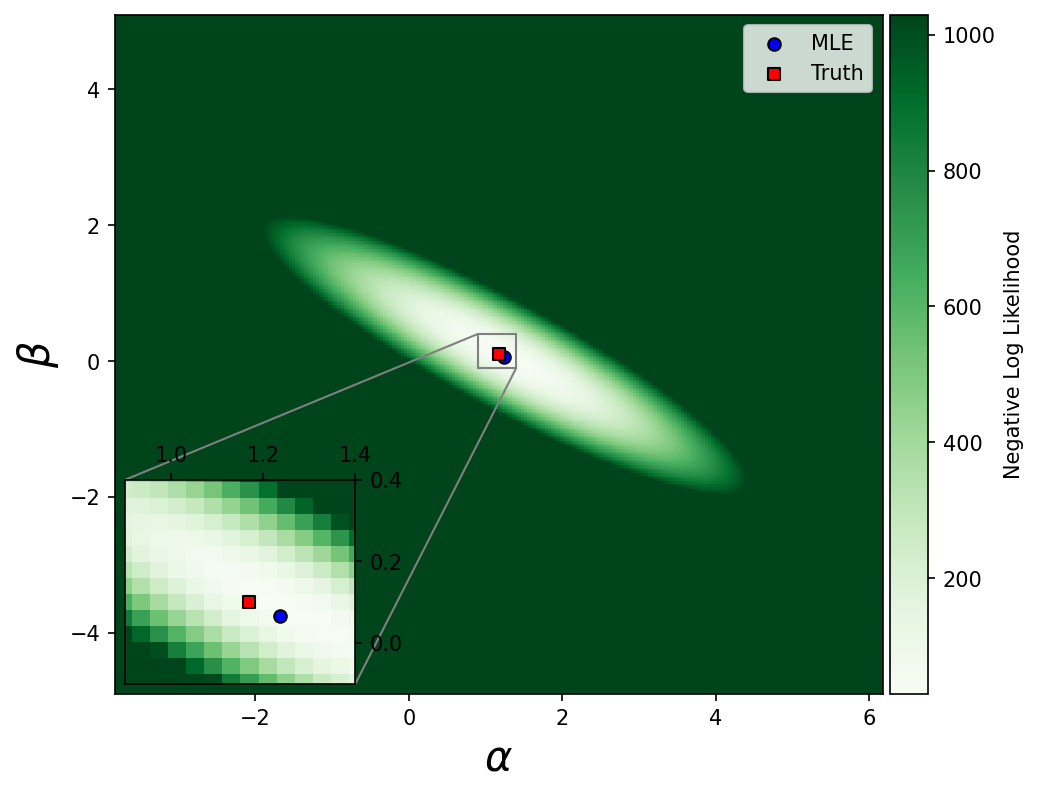

In [10]:
#plot

# this is really messy code!

# oh well...............


fig, ax = plt.subplots(figsize=[7,6])
im = ax.pcolormesh(a_grid, b_grid, negative_ln_likelihood_vals, cmap='Greens',vmin=negative_ln_likelihood_vals.min(), vmax=negative_ln_likelihood_vals.min()+1000) # arbitrary scale
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)


fig.colorbar(im, cax=cax, orientation='vertical',label='Negative Log Likelihood')

# add inset axes
axins = zoomed_inset_axes(ax, zoom=6, loc=3)
axins.pcolormesh(a_grid, b_grid, negative_ln_likelihood_vals, cmap='Greens',vmin=negative_ln_likelihood_vals.min(), vmax=negative_ln_likelihood_vals.min()+100) # arbitrary scale
axins.scatter(results['x'][0],results['x'][1],marker='o',c='blue',edgecolor='k',label='MLE')
axins.scatter(1.17,0.1,label='Truth',marker='s',c='red',edgecolor='k')

# sub region of the original image
x1, x2, y1, y2 = 0.9, 1.4, -0.1, 0.4
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.xaxis.tick_top()
axins.yaxis.tick_right()
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


ax.scatter(results['x'][0],results['x'][1],marker='o',c='blue',edgecolor='k',label='MLE')
ax.scatter(1.17,0.1,label='Truth',marker='s',c='red',edgecolor='k')
ax.legend()
ax.set_xlabel('$\\alpha$',fontsize=20)
ax.set_ylabel('$\\beta$',fontsize=20)

Compare the MLE and polyfit results!

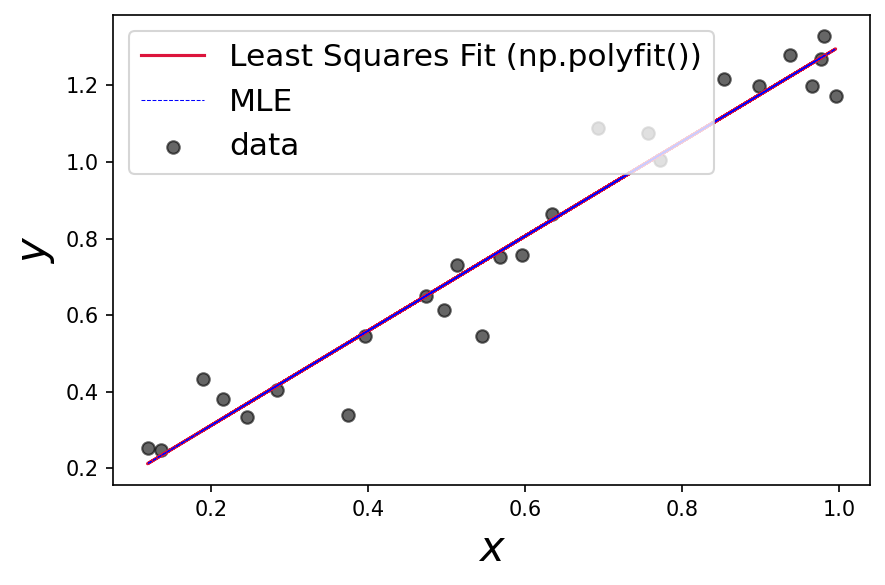

In [11]:
plt.figure()
plt.scatter(x, y, c='k',marker='o', label='data',alpha=0.6)
plt.plot(x, alpha_fit*x + beta_fit, c='crimson', label='Least Squares Fit (np.polyfit())')
plt.plot(x, results['x'][0]*x + results['x'][1], c='blue', label='MLE',ls='dashed',lw=0.5)
plt.legend(fontsize=15)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$y$',fontsize=20)
plt.tight_layout()